In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.


In [2]:
# load training data
labeled_images = pd.read_csv('data/train.csv')
images = labeled_images.iloc[0:5000,1:]
labels = labeled_images.iloc[0:5000,:1]

x_train, x_test, y_train, y_test = train_test_split(images, labels, train_size=0.8, random_state=0)

/Users/tsteidle/miniconda2/envs/drlnd/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [3]:
batch_size = 128
num_classes = 10
epochs = 15

# input image dimensions
img_rows, img_cols = 28, 28

In [4]:
# reshape images
x_train = x_train.values.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.values.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

# print shapes for control
print('x_train shape:', x_train.shape)
print('x_train shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (4000, 28, 28, 1)
x_train shape: (1000, 28, 28, 1)
4000 train samples
1000 test samples


In [6]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#### Image augmentation

In [7]:
datagen = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False,
        samplewise_std_normalization = False,
        zca_whitening = False,
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        horizontal_flip = False,
        vertical_flip = False)

datagen.fit(x_train)

#### Training

In [8]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),
                 padding = 'Same', 
                 activation ='relu', 
                 input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),
                 padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3),
                 padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),
                 padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 4000 samples, validate on 1000 samples
Epoch 1/15
4000/4000 [==============================] - 18s 4ms/step - loss: 1.1906 - acc: 0.5970 - val_loss: 0.4043 - val_acc: 0.8780
Epoch 2/15
4000/4000 [==============================] - 18s 4ms/step - loss: 0.3298 - acc: 0.8930 - val_loss: 0.2053 - val_acc: 0.9410
Epoch 3/15
4000/4000 [==============================] - 18s 5ms/step - loss: 0.2059 - acc: 0.9370 - val_loss: 0.2472 - val_acc: 0.9160
Epoch 4/15
4000/4000 [==============================] - 20s 5ms/step - loss: 0.1613 - acc: 0.9490 - val_loss: 0.2092 - val_acc: 0.9400
Epoch 5/15
4000/4000 [==============================] - 19s 5ms/step - loss: 0.1271 - acc: 0.9595 - val_loss: 0.1522 - val_acc: 0.9580
Epoch 6/15
4000/4000 [==============================] - 18s 5ms/step - loss: 0.0963 - acc: 0.9705 - val_loss: 0.0946 - val_acc: 0.9710
Epoch 7/15
4000/4000 [==============================] - 18s 5ms/step - loss: 0.0912 - acc: 0.9698 - val_loss: 0.0970 - val_acc: 0.9710
Epoch 8

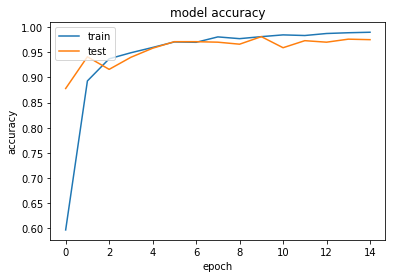

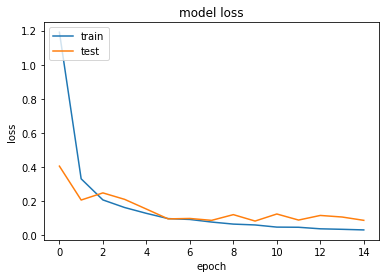

In [9]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 2. Write Results to File

In [10]:
test_data = pd.read_csv('data/test.csv')
test_data[test_data>0]=1
test_data = test_data.values.reshape(test_data.shape[0], img_rows, img_cols, 1)
results = model.predict(test_data)
results = np.argmax(results,axis = 1)

df = pd.DataFrame(results)
df.index.name='ImageId'
df.index+=1
df.columns=['Label']
df.to_csv('data/submission.csv', header=True)